### Lesion Segmentation

This is the example notebook to run both binary and multiclass lesion segmentation with UNET.

This notebook assumes the following project structure:
```bash
Root
├── notebooks
│   └── notebook1.ipynb
└── data
    └── IDRID
        ├── 1. Original Images
        │   ├── a. Training Set
        │   └── b. Testing Set
        └── 2. All Segmentation Groundtruths
            ├── a. Training Set
            └── b. Testing Set
                ├── 1. Microaneurysms
                ├── 2. Haemorrhages
                ├── 3. Hard Exudates
                ├── 4. Soft Exudates
                └── 5. Optic Disc
```

If you do not have the dataset, you may download it here:<br>
https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid 

Please install the A. Segmentation.zip and move the dataset into this folder structure

In [1]:
# Imports
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image, ImageOps
import numpy as np
import random
from tqdm import tqdm
import math
import pandas as pd
import gc

### UNET model Architecture

UNET is made out of 3 main architectures
1. Encoder block made out of convolutional blocks
2. BottleNeck layer made out of 2 conv2d
3. Decoder block made out of transpose convolutional blocks


In [2]:
class conv_block(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):

    super(conv_block, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels, out_channels, 3, padding=1)
    self.bn1 = torch.nn.BatchNorm2d(out_channels)
    self.conv2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
    self.bn2 = torch.nn.BatchNorm2d(out_channels)
    self.relu = torch.nn.ReLU()

  def forward(self, inputs):
    x = self.relu(self.bn1(self.conv1(inputs)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x

In [3]:
class encoder_block(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(encoder_block, self).__init__()
    self.conv = conv_block(in_channels, out_channels)
    self.maxpool = torch.nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.maxpool(x)
    return x, p

In [4]:
class decoder_block(torch.nn.Module):
  def __init__(self, in_channels:int, out_channels:int):
    super(decoder_block, self).__init__()
    self.upsample = torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    self.conv = conv_block(out_channels+out_channels, out_channels)

  def forward(self, inputs, skip_connections):
    x = self.upsample(inputs)
    x = torch.cat((x, skip_connections), 1)
    return self.conv(x)

In [5]:
class uNetModel(torch.nn.Module):
  def __init__(self, n_classes):
    super(uNetModel, self).__init__()
    #--------------------------
    # Encoder
    #--------------------------
    self.encoder1 = encoder_block(3, 64)
    self.encoder2 = encoder_block(64, 128)
    self.encoder3 = encoder_block(128, 256)
    self.encoder4 = encoder_block(256, 512)

    #--------------------------
    # Bottleneck
    #--------------------------
    self.bottleneck = conv_block(512, 1024)

    #--------------------------
    # Encoder
    #--------------------------
    self.decoder1 = decoder_block(1024, 512)
    self.decoder2 = decoder_block(512, 256)
    self.decoder3 = decoder_block(256, 128)
    self.decoder4 = decoder_block(128, 64)

    #--------------------------
    # Classifier
    #--------------------------
    self.classifier = torch.nn.Conv2d(64, n_classes, 1)

  def forward(self, inputs):
    x1, p1 = self.encoder1(inputs)
    x2, p2 = self.encoder2(p1)
    x3, p3 = self.encoder3(p2)
    x4, p4 = self.encoder4(p3)
    b = self.bottleneck(p4)

    d1 = self.decoder1(b, x4)
    d2 = self.decoder2(d1, x3)
    d3 = self.decoder3(d2, x2)
    d4 = self.decoder4(d3, x1)

    output = self.classifier(d4)
    return output

### Loss Functions

Contains the following classes of different loss functions:
1. DiceLoss
2. FocalLoss
3. TverskyLoss
4. FocalTverskyLoss
5. LogCoshDice

In [6]:
def one_hot_encode(n_classes:int, y:Tensor):
    """
    Function that converts input into tensor with one hot encoding for each class
    Eg. [1,2,0,1,1] -> [[0, 0, 1, 0, 0], [1, 0, 0, 1, 1], [0, 1, 0, 0, 0]]

    Args:
        n_classes (int): number of classes in y
        y (Tensor): input to be split into one hot encoding

    Returns:
        tensor object of one hot encoding
    """
    y = y.long() #convert to ints first (class values)
    batch_size, _, height, width = y.size()
    one_hot = torch.zeros(batch_size, n_classes, height, width, device=y.device) #create base case
    return one_hot.scatter_(1, y, 1)


class DiceLoss(torch.nn.Module):
    """
    Function to calculate Dice Loss
        DL(y,p) = 1 - 2(yp + e) / (y + p + e) 
    
    where y = y_true, p = y_pred, e = epsilon to ensure no divisible by 0

    Args:
        n_classes (int): number of classes 
        reduction (str, optional): Reduction method, either only mean or sum. Defaults to mean
        eps (float, optional): Value to avoid undefined edge cases. Defaults to 1e-6.

    Returns:
        dice loss
    """
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.epsilon = eps
        
        if reduction in ["mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        assert y_true.size() == y_pred.size() #checking pred and true has the same size

        intersection = (y_pred * y_true).sum(dim=(2, 3)) #yp
        union = y_pred.sum(dim=(2,3)) + y_true.sum(dim=(2,3)) #y+p

        soft_dice_loss = (2.0* (intersection + self.epsilon)) / (union + self.epsilon)
        
        if self.reduction  == "mean":
            return 1.0 - torch.mean(soft_dice_loss)
        
        else:
            return 1.0 - torch.sum(soft_dice_loss)



class FocalLoss(torch.nn.Module):
    """
    Function to calculate Focal Loss
        FL(p, y) = -alpha * ((1-pt) ** gamma) * log(pt) 
    where log(pt) is the cross entropy loss, p = prediction, y = true value

    Args:
        n_classes (int): num of classes
        alpha (float, optional): alpha value, adds weights to help with class imbalance. Defaults to 0.25.
        gamma (float, optional): gamma value, controls the shape of loss curve for pioritising. Defaults to 2.0.
        reduction (str, optional): reudction method, either none, mean or sum. Defaults to "mean".
    """
    def __init__(self, n_classes:int, weights:Tensor=None, alpha:float=0.75, gamma:float=2.0, reduction:str="mean"):
        super(FocalLoss, self).__init__()
        self.n_classes = n_classes
        self.weights = weights
        self.alpha = alpha
        self.gamma = gamma

        if reduction in ["none", "mean", "sum"]:
            self.reduction = reduction
        else:
            raise Exception("Invalid Reduction Method Selected. Please choose between none, mean and sum.")
    
    
    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_pred, y_true.float(), pos_weight=self.weights, reduction=self.reduction) #-log(pt)

        if self.n_classes > 1: #multiclass classification
            y_true = torch.squeeze(y_true.long(), dim=1) #squeeze class layer as cross entropy expect (batch_size, h, w)
            loss = torch.nn.functional.cross_entropy(y_pred, y_true, weight=self.weights,  reduction=self.reduction) #-log(pt)

        exp_loss = torch.exp(-loss) #pt
        focal_loss = self.alpha * torch.pow((1.0-exp_loss), self.gamma) * loss
        #reduction already done in the loss calculation, just return focal loss

        return focal_loss
    


class TverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, eps:float=1e-6):
        super(TverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.beta = beta
        self.eps = eps

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        if self.n_classes == 1: #binary classification, of 1 or 0s, sigmoid
            y_pred = torch.nn.functional.sigmoid(y_pred)

        if self.n_classes > 1: #multiclass classification
            y_pred = torch.nn.functional.softmax(y_pred, dim=1)
            y_true =  one_hot_encode(self.n_classes, y_true)

        true_positive = (y_pred * y_true).sum(dim=(2, 3)) #yp
        false_negative =  ((1-y_pred) * y_true).sum(dim=(2,3)) #(1-p)y
        false_positive = (y_pred * (1-y_true)).sum(dim=(2,3)) #(1-y)p

        tversky_loss = true_positive / (true_positive + self.beta*false_negative + (1-self.beta)*false_positive + self.eps)
        return 1- torch.mean(tversky_loss)
    


class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, n_classes:int, beta:float=0.5, gamma:float=0.75, eps:float=1e-6):
        super(FocalTverskyLoss, self).__init__()
        self.treversky = TverskyLoss(n_classes, beta, eps)
        self.gamma = gamma

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        treversky_loss = self.treversky(y_pred, y_true)
        focal_tversky_loss = torch.pow(treversky_loss, self.gamma)
        return focal_tversky_loss


class LogCoshDice(torch.nn.Module):
    def __init__(self, n_classes:int, reduction:str="mean", eps:float=1e-6):
        super(LogCoshDice, self).__init__()
        self.diceloss = DiceLoss(n_classes, reduction, eps)

    def forward(self, y_pred:Tensor, y_true:Tensor):
        """
        y_pred (Tensor): model prediction
        y_true (Tensor): true value
        """
        dice_loss = self.diceloss(y_pred, y_true)
        return torch.log(torch.cosh(dice_loss))

### Train, Eval, Inference Functions

In [7]:
def train_unet(model, criterion, optimiser, dataloader, num_epochs, device, model_name):
    model.to(device)
    model.train()
    loss_container = []

    for epoch in range(num_epochs):
        total_loss = 0
        for idx, (image, mask) in enumerate(tqdm(dataloader)):
            (image, mask) = (image.to(device), mask.to(device))
            outputs = model(image)

            if isinstance(criterion, torch.nn.BCEWithLogitsLoss):
                loss = criterion(outputs, mask.float())
            
            elif isinstance(criterion, torch.nn.CrossEntropyLoss):
                loss = criterion(outputs, torch.squeeze(mask, dim=1))
            
            else:
                loss = criterion(outputs, mask)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        if len(loss_container) > 0  and avg_loss < min(loss_container) and model_name != None:
            torch.save(model, f"../models/lesion/{model_name}.pt")
        
        loss_container.append(avg_loss)
        print(f"Epoch {epoch+1} completed, training loss: {avg_loss:.2f}")
    
    if model_name != None:
        torch.save(model, f"../models/lesion/{model_name}_{num_epochs}.pt")

    return loss_container

In [8]:
def dice_coefficient(preds:Tensor, labels:Tensor, multiclass:bool):
    """
    Function to calculate dice coefficient
    
    Args:
        preds (Tensor): Predicted tensor.
        labels (Tensor): Ground truth tensor.
    
    Returns:
        float: Dice Coefficient.
    """    

    n_classes = preds.size()[1]
    dice = []

    if multiclass:
        preds = torch.argmax(preds, dim=1, keepdim=True)
        #label size = [batch_size, num_class, h, w]
        labels =  one_hot_encode(n_classes, labels)
        preds = one_hot_encode(n_classes, preds)

    else:
        preds = (preds > 0.5).float()

    for i in range(n_classes):    
        pred_f = preds[:, i, :, :].flatten()
        labels_f = labels[:, i, :, :].flatten()

        # Calculate Intersection and twice the sum of both predictions and labels
        intersection = (pred_f * labels_f).sum().item()
        total = (pred_f + labels_f).sum().item()

        dice.append((2. * intersection) / total)
    
    return sum(dice) / len(dice)


def jaccard_index(preds:Tensor, labels:Tensor, multiclass:bool):
    """
    Function to calculate jaccard_index, IOU
    Args:
        preds (Tensor): Predicted tensor.
        labels (Tensor): Ground truth tensor.
    
    Returns:
        float: Jaccard Index.
    """    
    n_classes = preds.size()[1]
    jaccard = []

    if multiclass:
        preds = torch.argmax(preds, dim=1, keepdim=True)
        #label size = [batch_size, num_class, h, w]
        labels =  one_hot_encode(n_classes, labels)
        preds = one_hot_encode(n_classes, preds)

    else:
        preds = (preds > 0.5).float()

    for i in range(n_classes):    
            pred_f = preds[:, i, :, :].flatten()
            labels_f = labels[:, i, :, :].flatten()

            # Calculate Intersection and twice the sum of both predictions and labels
            intersection = (pred_f * labels_f).sum().item()
            total = (pred_f + labels_f).sum().item()
            union = total - intersection

            jaccard.append( intersection/union )

    return sum(jaccard) / len(jaccard)

def eval_unet(model:uNetModel, multiclass:bool,  dataloader, device:str):
    """
    Function to evaluate UNET inference using dice coefficient and jaccard index

    Args:
        model (uNetModel): unet model for evalutation
        multiclass (bool): segmentation problem a binary or multiclass
        dataloader: evaluation dataloader
        device (str): cuda or cpu
    """
    model.eval() 
    jaccard_scores = []
    dice_scores = []

    with torch.no_grad(): 
        for idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            if multiclass:
                outputs = torch.nn.functional.softmax(outputs, dim=1)

            else:    
                outputs = torch.nn.functional.sigmoid(outputs)

            # Calculate metrics for each batch and append to list
            jaccard_scores.append(jaccard_index(outputs, masks, multiclass))
            dice_scores.append(dice_coefficient(outputs, masks, multiclass))

    # Compute average scores
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    print(f"Average Dice Coefficient: {avg_dice}")
    print(f"Average Jaccard Index: {avg_jaccard}")

    return avg_dice, avg_jaccard

In [9]:
def inference_unet(model, multiclass, dataloader, num_images, device, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
    model.to(device)
    model.eval()

    image_index = 0
    image_per_batch = math.ceil(num_images/len(dataloader))
    with torch.no_grad():
        for idx in range(min(len(dataloader), num_images)):
            image, mask = next(iter(dataloader))
            outputs = model(image.to(device))

            if multiclass:
                outputs = torch.nn.functional.softmax(outputs)
                predictions = torch.argmax(outputs, dim=1)

            else:    
                outputs = torch.nn.functional.sigmoid(outputs)
                predictions = (outputs > 0.5).float()

            for i in range(image_per_batch):
                image = unnormalize(image[i], mean, std)
                image_np = np.array(image).transpose(1, 2, 0)
                pred_np = np.array(predictions[i].cpu())
                
                fig, axes = plt.subplots(1, 3, figsize=(10, 5))
                axes[0].imshow(image_np)  # Assuming batch size is 1
                axes[0].set_title('Input')
                axes[0].axis('off')
                axes[1].imshow(pred_np.squeeze(), cmap="gray")  # Assuming batch size is 1
                axes[1].set_title('UNET Prediction')
                axes[1].axis('off')
                axes[2].imshow(np.array(mask[i]).squeeze(), cmap='gray')
                axes[2].set_title('True Value')
                axes[2].axis('off')
                plt.show()

                image_index += 1
                if image_index == num_images:
                    break

### Dataset Preprocessing & Visualisation

Common Functions used in both binary and multiclass segmentation

In [10]:
def enhance_contrast(image:Image, show_image:bool):    
    image = np.array(image)
    r,g,b = cv2.split(image) #extract out green channel

    green_channel = cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)  # convert green channel to RGB
    lab = cv2.cvtColor(green_channel, cv2.COLOR_RGB2LAB)  # convert rgb image to lab channels

    L, a, b = cv2.split(lab)  # split lab channels

    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))  # create CLAHE
    cL = clahe.apply(L)  # apply CLAHE to enhance contrast

    new_img = cv2.merge((cL, a, b))  # create new lab enhanced image
    enhanced_img = cv2.cvtColor(new_img, cv2.COLOR_LAB2RGB) # convert from lab to rgb


    if show_image:
        resized_enhanced_img = cv2.resize(enhanced_img, (224,224))
        cv2.imshow("", resized_enhanced_img)
        cv2.waitKey(10000)
        cv2.destroyAllWindows()
    
    return Image.fromarray(enhanced_img)

In [11]:
class ToTensorWithoutScaling(object):
    def __call__(self, pic):
        """|
        Convert a PIL Image or numpy.ndarray to tensor without normalizing.
        """
        return (transforms.functional.to_tensor(pic) * 255).to(torch.int64)


In [12]:
def unnormalize(image:np.array, mean:np.array, std:np.array):
    """
    Function to unnormalize an image given its mean and std

    Args:
        image (np.array): Numpy array of the image
        mean (np.array): Numpy array of the mean
        std (np.array): Numpy array of the std

    Returns:
        Unnormalised numpy array of the image
    """

    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)    # for inplace operations
    return image


def visualise_dataset(dataloader, num_images=9, mean=[0.2816, 0.2817, 0.2816], std=[0.1992, 0.1991, 0.1991]):
  images, masks = next(iter(dataloader))
  print(f"Image batch shape: {images.size()}")
  print(f"Masks batch shape: {masks.size()}")

  fig, axs = plt.subplots(num_images, 2, figsize=(8, 12), squeeze=False)

  for i in range(num_images):
    img = images[i].squeeze()
    img = unnormalize(img, mean, std)  # Unnormalize the image
    img = np.transpose(img.numpy(), (1, 2, 0))

    mask = masks[i].squeeze()
    mask = mask.numpy()

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Image')

    axs[i, 1].imshow(mask.squeeze(), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Mask')

  plt.tight_layout()
  plt.show()

### Binary Image Segmenetation

In [44]:
class BinarySegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, mask_class, transform, masktransform, mean, std):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mask_class = mask_class        
        self.transform = transform
        self.masktransform = masktransform
        self.mean = mean
        self.std = std
        
        self.image_list = os.listdir(image_paths)
        self.mask_list = []
        for dir in mask_class:
            self.mask_list.append(os.listdir(f"{mask_paths}/{dir[0]}"))


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = f"{self.image_paths}/{image_name}"
        image = Image.open(image_path)
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image
        merged_mask = np.zeros((image.size[1],image.size[0]), dtype=np.uint8)

        for class_idx, mask_dir in enumerate(self.mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif"
            if mask_name in self.mask_list[class_idx]:
                mask = Image.open(f"{self.mask_paths}/{mask_dir[0]}/{mask_name}").convert('L')
                mask_array = np.array(mask)
                merged_mask[mask_array > 0] = 1 #fixed class of 1 

        mask = Image.fromarray(merged_mask)

  
        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            mask = self.masktransform(mask)


        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std

        return enhanced_image, mask

In [45]:
#hyper parameters
image_size = (512,512)
batch_size = 9

In [46]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    ToTensorWithoutScaling()
])

aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor(),
])

mask_aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
train_dataset = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [train_dataset]
#augmented data
for i in range(2):
  augmented_data = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=aug_transform,
                              masktransform=mask_aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

total_train_dataset = ConcatDataset(total_data)

test_dataset = BinarySegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set',
                              mask_paths = test_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
train_dataloader = DataLoader(total_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
visualise_dataset(train_dataloader, 1)

In [ ]:
class_frequencies = np.zeros(2)
for idx, (image, mask) in enumerate(train_dataloader):
    class_frequencies += np.bincount(mask.flatten(), minlength=2)

pos_weight = class_frequencies[0]/class_frequencies[1]
print(class_frequencies)
print(pos_weight)

#### Training

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.BCEWithLogitsLoss(),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device)),
                  torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4, dtype=torch.float32).to(device)),
                  DiceLoss(1),
                  FocalLoss(1, weights=torch.tensor(4).to(device)),
                  TverskyLoss(1),
                  TverskyLoss(1, 0.25),
                  TverskyLoss(1, 0.75),
                  FocalTverskyLoss(1),
                  LogCoshDice(1)]

model_names = ["binary/BCEnoPOS",
               "binary/BCECalcPOS",
               "binary/BCE4POS",
               "binary/DiceLoss",
               "binary/FocalLoss",
               "binary/TverskyLossBase",
               "binary/TverskyLoss25",
               "binary/TverskyLoss75",
               "binary/FocalTverskyLoss",
               "binary/LogCoshDice"]

loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):

    model = uNetModel(1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_names[idx]} model")
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               train_dataloader,
                               50,
                               device,
                               model_names[idx])
    
    loss_dataframe[model_names[idx]] = training_loss

    del model
    torch.cuda.empty_cache()
    gc.collect()

loss_dataframe.to_csv('results/binary.csv')

#### Evaluation

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["binary/BCEnoPOS",
               "binary/BCECalcPOS",
               "binary/BCE4POS",
               "binary/DiceLoss",
               "binary/FocalLoss",
               "binary/TverskyLossBase",
               "binary/TverskyLoss25",
               "binary/TverskyLoss75",
               "binary/FocalTverskyLoss",
               "binary/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

In [48]:
results = pd.DataFrame(columns=['model', 'dice coefficient', 'jaccard index'])

for idx, (best_model, last_model) in enumerate(models_list):
    torch.cuda.empty_cache()
    gc.collect()
    b_dice_coe, b_jaccard = eval_unet(best_model, False, test_dataloader, device)
    l_dice_coe, l_jaccard = eval_unet(last_model, False, test_dataloader, device)

    results.loc[len(results)] = [f"{model_names[idx]}_best", b_dice_coe, b_jaccard]
    results.loc[len(results)] = [f"{model_names[idx]}_last", l_dice_coe, l_jaccard]

results.to_csv('binary_results.csv')

Average Dice Coefficient: 0.6487987694513286
Average Jaccard Index: 0.480674127514322
Average Dice Coefficient: 0.6487987694513286
Average Jaccard Index: 0.480674127514322
Average Dice Coefficient: 0.6263352691412728
Average Jaccard Index: 0.45657719792205215
Average Dice Coefficient: 0.5212941719164877
Average Jaccard Index: 0.35312251192863336
Average Dice Coefficient: 0.7332796702130276
Average Jaccard Index: 0.5796318408788887
Average Dice Coefficient: 0.7344574333261269
Average Jaccard Index: 0.5818263850367236
Average Dice Coefficient: 0.7880173832320265
Average Jaccard Index: 0.6510113281097517
Average Dice Coefficient: 0.7880173832320265
Average Jaccard Index: 0.6510113281097517
Average Dice Coefficient: 0.6245579199466874
Average Jaccard Index: 0.4545620772179568
Average Dice Coefficient: 0.6593294670068267
Average Jaccard Index: 0.4923578991388642
Average Dice Coefficient: 0.7925380820042266
Average Jaccard Index: 0.6571381274841706
Average Dice Coefficient: 0.792538082004226

#### Inference

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["binary/BCEnoPOS",
               "binary/BCECalcPOS",
               "binary/BCE4POS",
               "binary/DiceLoss",
               "binary/FocalLoss",
               "binary/TverskyLossBase",
               "binary/TverskyLoss25",
               "binary/TverskyLoss75",
               "binary/FocalTverskyLoss",
               "binary/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

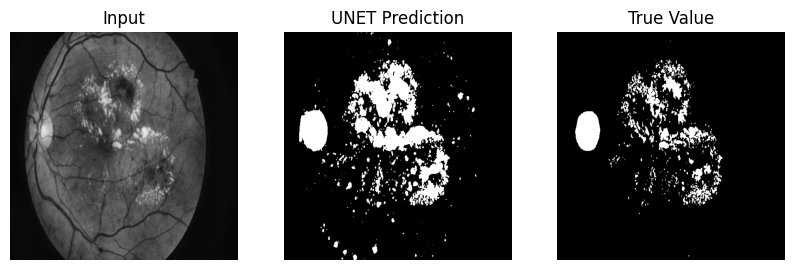

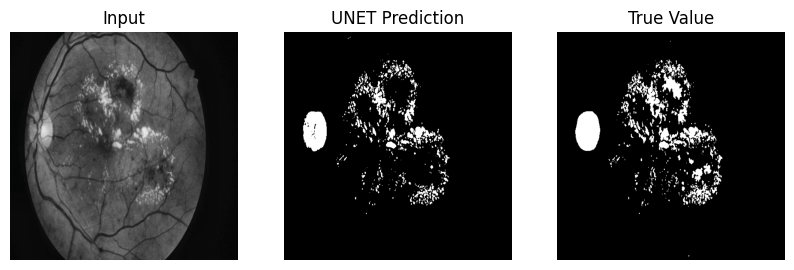

In [ ]:
best_model, model_type = models_list[1]
torch.cuda.empty_cache()
gc.collect()
inference_unet(best_model, False, test_dataloader, 1, device)
inference_unet(last_model, False, test_dataloader, 1, device)

### MultiClass Image Segmentation

In [13]:
class MultiClassSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, mask_class, transform, masktransform, mean, std):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.mask_class = mask_class        
        self.transform = transform
        self.masktransform = masktransform
        self.mean = mean
        self.std = std
        
        self.image_list = os.listdir(image_paths)
        self.mask_list = []
        for dir in mask_class:
            self.mask_list.append(os.listdir(f"{mask_paths}/{dir[0]}"))


    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = f"{self.image_paths}/{image_name}"
        image = Image.open(image_path)
        enhanced_image = enhance_contrast(image, False) #enhance contrast of image
        merged_mask = np.zeros((image.size[1],image.size[0]), dtype=np.uint8)

        for class_idx, mask_dir in enumerate(self.mask_class):
            mask_name = f"{image_name[:-4]}_{mask_dir[1]}.tif"
            if mask_name in self.mask_list[class_idx]:
                mask = Image.open(f"{self.mask_paths}/{mask_dir[0]}/{mask_name}").convert('L')
                mask_array = np.array(mask)
                merged_mask[mask_array > 0] = class_idx+1

        mask = Image.fromarray(merged_mask)

        seed = np.random.randint(2147483647) # make a seed with numpy generator

        if self.transform is not None:
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            enhanced_image = self.transform(enhanced_image)
            random.seed(seed) # apply this seed to img transforms
            torch.manual_seed(seed)
            mask = self.masktransform(mask)


        #normalising image
        mean = torch.tensor(self.mean).reshape(-1, 1, 1)
        std = torch.tensor(self.std).reshape(-1, 1, 1)

        enhanced_image = ( enhanced_image - mean )/std

        return enhanced_image, mask

In [14]:
#hyper parameters
image_size = (512,512)
batch_size = 9

In [15]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize(image_size),
    ToTensorWithoutScaling()
])

aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    transforms.ToTensor(),
])

mask_aug_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation((-45,45)),
    ToTensorWithoutScaling()
])

train_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set"
test_mask_file = "../input/IDRID/A.%20Segmentation/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set"
class_path = [["1. Microaneurysms","MA"], ["2. Haemorrhages","HE"], ["3. Hard Exudates","EX"], ["4. Soft Exudates","SE"], ["5. Optic Disc", "OD"]]

# Initialize your dataset - 1/3 unagumented and 2/3 augmented
multiclass_train_dataset = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
total_data = [multiclass_train_dataset]
#augmented data
for i in range(2):
  augmented_data = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/a. Training Set',
                              mask_paths = train_mask_file,
                              mask_class=class_path,
                              transform=aug_transform,
                              masktransform=mask_aug_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])
  total_data.append(augmented_data)

multiclass_total_train_dataset = ConcatDataset(total_data)

multiclass_test_dataset = MultiClassSegmentationDataset(image_paths = '../input/IDRID/A.%20Segmentation/A. Segmentation/1. Original Images/b. Testing Set',
                              mask_paths = test_mask_file,
                              mask_class=class_path,
                              transform=transform,
                              masktransform=mask_transform,
                              mean=[0.2816, 0.2817, 0.2816],
                              std=[0.1992, 0.1991, 0.1991])

# Initialize the dataloader
multiclass_train_dataloader = DataLoader(multiclass_total_train_dataset, batch_size=batch_size, shuffle=True)
multiclass_test_dataloader = DataLoader(multiclass_test_dataset, batch_size=batch_size, shuffle=False)

Image batch shape: torch.Size([9, 3, 512, 512])
Masks batch shape: torch.Size([9, 1, 512, 512])


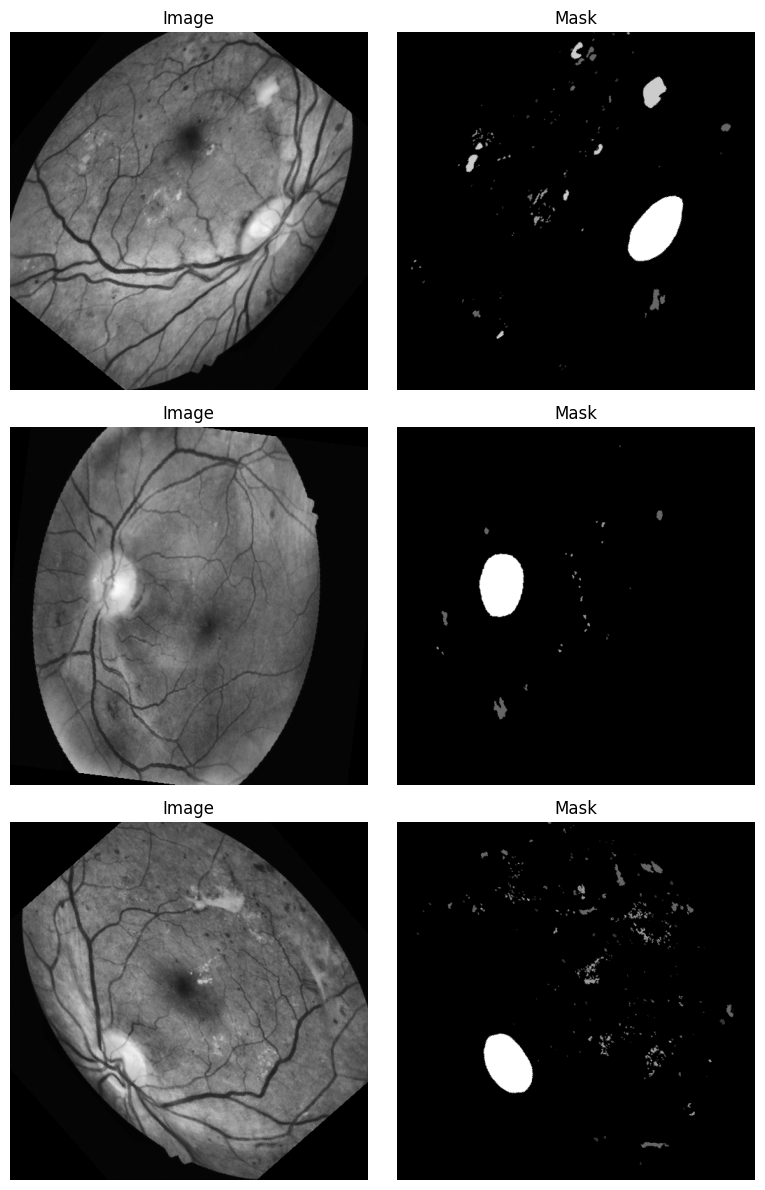

In [ ]:
visualise_dataset(multiclass_train_dataloader, 3)

In [ ]:
class_frequencies = np.zeros(6)
for idx, (image, mask) in enumerate(multiclass_train_dataloader):
    class_frequencies += np.bincount(mask.flatten(), minlength=6)
# Compute inverse class frequencies
inverse_class_frequencies = 1 / class_frequencies

# Normalize weights
class_weights = inverse_class_frequencies / np.sum(inverse_class_frequencies)

print("Class Frequencies:", class_frequencies)
print("Inverse Class Frequencies:", inverse_class_frequencies)
print("Class Weights:", class_weights)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.CrossEntropyLoss(),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device)),
                  torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  DiceLoss(6),
                  FocalLoss(6, weights=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device)),
                  TverskyLoss(6),
                  TverskyLoss(6, 0.25),
                  TverskyLoss(6, 0.75),
                  FocalTverskyLoss(6),
                  LogCoshDice(6)]

model_names = ["multiclass/CEL",
               "multiclass/CELCalcWeights",
               "multiclass/CELCustWeights",
               "multiclass/DiceLoss",
               "multiclass/FocalLoss",
               "multiclass/TverskyLossBase",
               "multiclass/TverskyLoss25",
               "multiclass/TverskyLoss75",
               "multiclass/FocalTverskyLoss",
               "multiclass/LogCoshDice"]

multiclass_loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):

    model = uNetModel(6)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_names[idx]} model")
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               multiclass_train_dataloader,
                               50,
                               device,
                               model_names[idx])
    
    multiclass_loss_dataframe[model_names[idx]] = training_loss

    del model
    torch.cuda.empty_cache()
    gc.collect()

multiclass_loss_dataframe.to_csv('results/multiclass.csv')

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion_list = [torch.nn.CrossEntropyLoss(weight=torch.tensor([1, 3, 3, 3, 3, 2], dtype=torch.float32).to(device))]

model_names = ["multiclass/CELCustWeights2"]

multiclass_loss_dataframe = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

for idx, criterion in enumerate(criterion_list):

    model = torch.load('../models/lesion/multiclass/CELCustWeights_50.pt')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(f"Training {model_names[idx]} model")
    training_loss = train_unet(model, 
                               criterion, 
                               optimizer,
                               multiclass_train_dataloader,
                               50,
                               device,
                               model_names[idx])
    
    multiclass_loss_dataframe[model_names[idx]] = training_loss

    del model
    torch.cuda.empty_cache()
    gc.collect()

multiclass_loss_dataframe.to_csv('multiclass.csv')

Training multiclass/CELCustWeights2 model


100%|██████████| 18/18 [00:49<00:00,  2.75s/it]


Epoch 1 completed, training loss: 0.16


100%|██████████| 18/18 [00:47<00:00,  2.67s/it]


Epoch 2 completed, training loss: 0.15


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Epoch 3 completed, training loss: 0.15


100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


Epoch 4 completed, training loss: 0.14


100%|██████████| 18/18 [00:51<00:00,  2.88s/it]


Epoch 5 completed, training loss: 0.14


100%|██████████| 18/18 [00:56<00:00,  3.13s/it]


Epoch 6 completed, training loss: 0.14


100%|██████████| 18/18 [00:55<00:00,  3.10s/it]


Epoch 7 completed, training loss: 0.13


100%|██████████| 18/18 [01:00<00:00,  3.34s/it]


Epoch 8 completed, training loss: 0.13


100%|██████████| 18/18 [00:59<00:00,  3.33s/it]


Epoch 9 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.22s/it]


Epoch 10 completed, training loss: 0.14


100%|██████████| 18/18 [00:57<00:00,  3.21s/it]


Epoch 11 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.19s/it]


Epoch 12 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.20s/it]


Epoch 13 completed, training loss: 0.12


100%|██████████| 18/18 [00:57<00:00,  3.22s/it]


Epoch 14 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.20s/it]


Epoch 15 completed, training loss: 0.15


100%|██████████| 18/18 [00:52<00:00,  2.94s/it]


Epoch 16 completed, training loss: 0.14


100%|██████████| 18/18 [00:51<00:00,  2.88s/it]


Epoch 17 completed, training loss: 0.13


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 18 completed, training loss: 0.13


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 19 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 20 completed, training loss: 0.12


100%|██████████| 18/18 [00:49<00:00,  2.72s/it]


Epoch 21 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 22 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 23 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 24 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 25 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 26 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 27 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 28 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 29 completed, training loss: 0.12


100%|██████████| 18/18 [00:49<00:00,  2.74s/it]


Epoch 30 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.21s/it]


Epoch 31 completed, training loss: 0.13


100%|██████████| 18/18 [00:51<00:00,  2.85s/it]


Epoch 32 completed, training loss: 0.14


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 33 completed, training loss: 0.13


100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


Epoch 34 completed, training loss: 0.13


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 35 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.72s/it]


Epoch 36 completed, training loss: 0.12


100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


Epoch 37 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 38 completed, training loss: 0.12


100%|██████████| 18/18 [00:49<00:00,  2.72s/it]


Epoch 39 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 40 completed, training loss: 0.12


100%|██████████| 18/18 [00:48<00:00,  2.71s/it]


Epoch 41 completed, training loss: 0.12


100%|██████████| 18/18 [00:49<00:00,  2.74s/it]


Epoch 42 completed, training loss: 0.17


100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


Epoch 43 completed, training loss: 0.15


100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


Epoch 44 completed, training loss: 0.14


100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


Epoch 45 completed, training loss: 0.13


100%|██████████| 18/18 [00:49<00:00,  2.77s/it]


Epoch 46 completed, training loss: 0.13


100%|██████████| 18/18 [00:49<00:00,  2.75s/it]


Epoch 47 completed, training loss: 0.13


100%|██████████| 18/18 [00:53<00:00,  2.98s/it]


Epoch 48 completed, training loss: 0.13


100%|██████████| 18/18 [00:57<00:00,  3.21s/it]


Epoch 49 completed, training loss: 0.13


100%|██████████| 18/18 [00:58<00:00,  3.25s/it]


Epoch 50 completed, training loss: 0.12


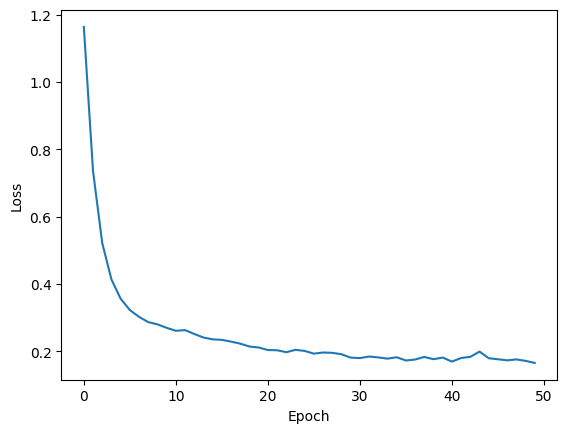

In [18]:
data = pd.read_csv('multiclass2.csv', header=0, index_col=0)
for model in data.columns:
    loss = data[model]
    plt.plot(loss.to_list(), label=model)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

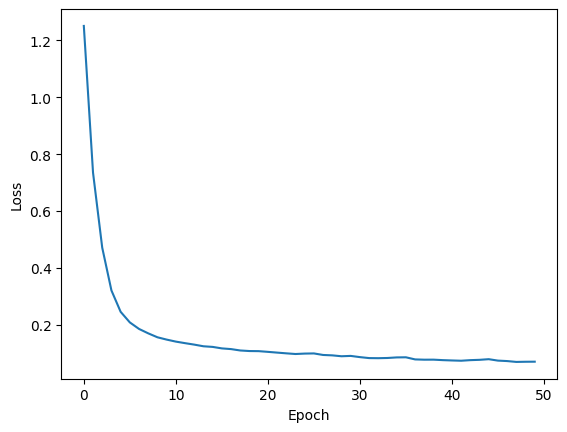

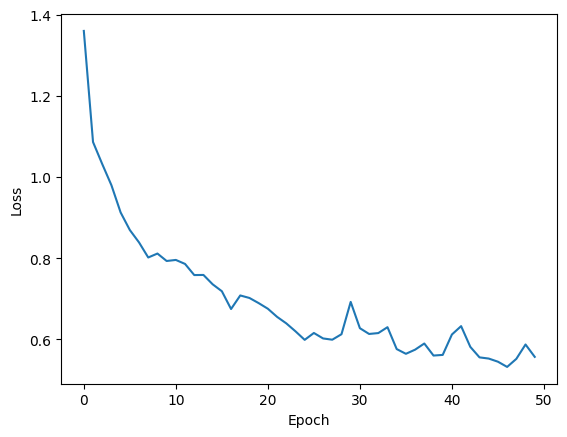

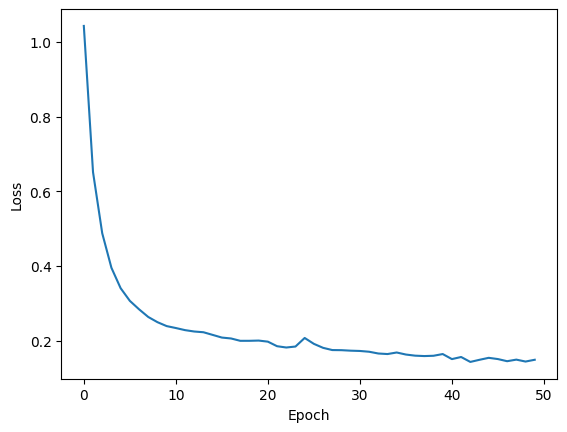

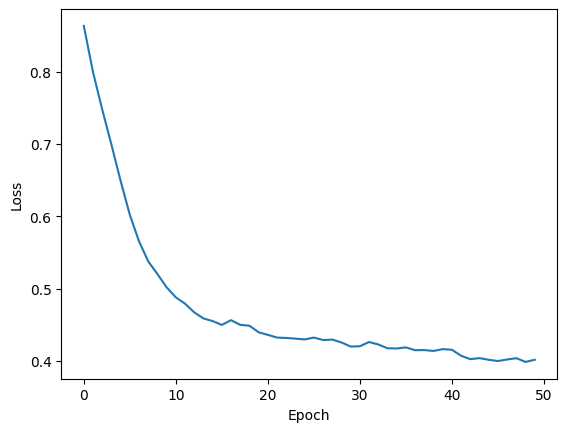

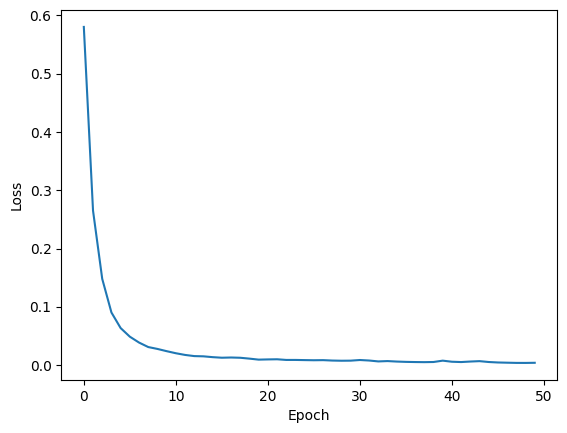

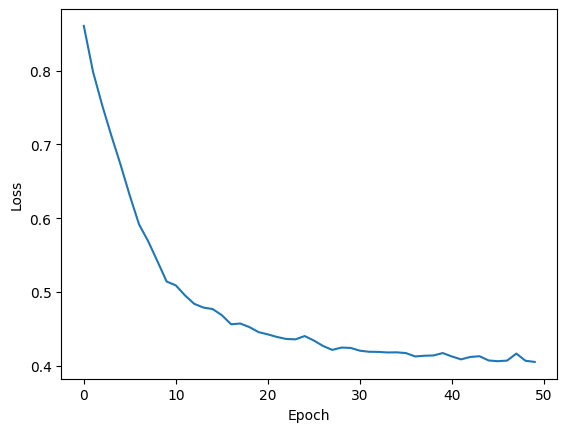

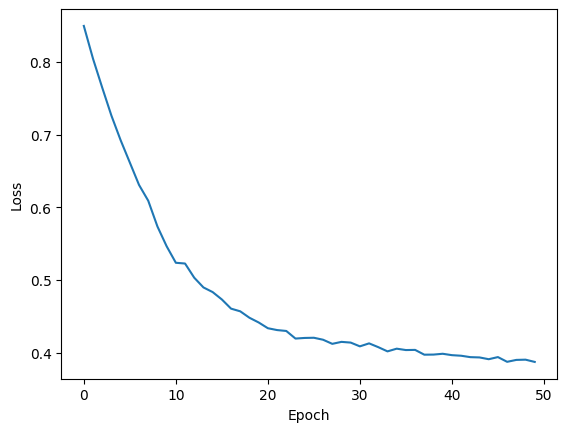

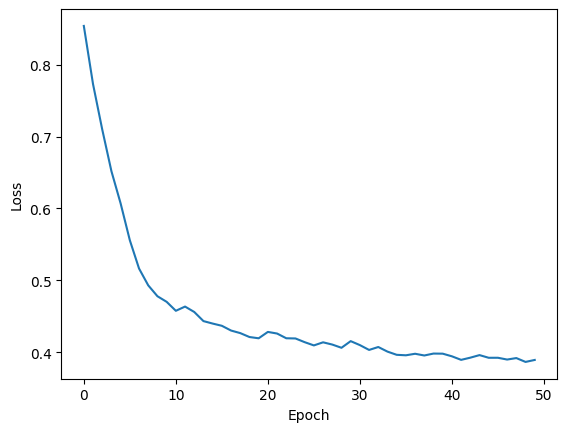

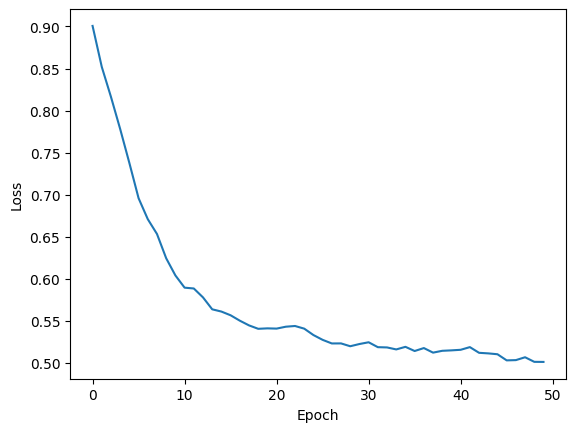

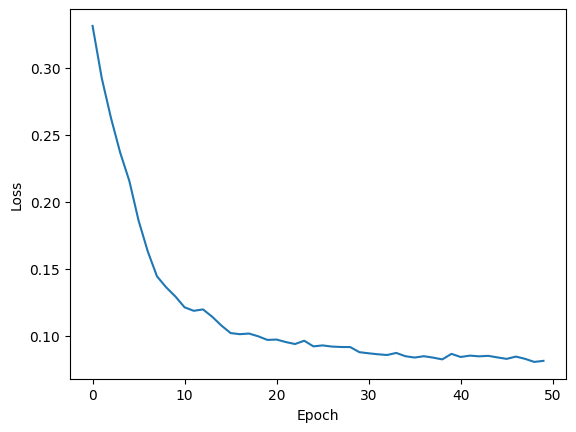

In [17]:
data = pd.read_csv('results/multiclass.csv', header=0, index_col=0)
for model in data.columns:
    loss = data[model]
    plt.plot(loss.to_list(), label=model)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

#### Evaluation

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["multiclass/CEL",
               "multiclass/CELCalcWeights",
               "multiclass/CELCustWeights",
               "multiclass/DiceLoss",
               "multiclass/FocalLoss",
               "multiclass/TverskyLossBase",
               "multiclass/TverskyLoss25",
               "multiclass/TverskyLoss75",
               "multiclass/FocalTverskyLoss",
               "multiclass/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

In [43]:
results = pd.DataFrame(columns=['model', 'dice coefficient', 'jaccard index'])

for idx, (best_model, last_model) in enumerate(models_list):
    torch.cuda.empty_cache()
    gc.collect()
    b_dice_coe, b_jaccard = eval_unet(best_model, True, multiclass_test_dataloader, device)
    l_dice_coe, l_jaccard = eval_unet(last_model, True, multiclass_test_dataloader, device)

    results.loc[len(results)] = [f"{model_names[idx]}_best", b_dice_coe, b_jaccard]
    results.loc[len(results)] = [f"{model_names[idx]}_last", l_dice_coe, l_jaccard]

results.to_csv('results/multiclass_results.csv')

Average Dice Coefficient: 0.5604691628791048
Average Jaccard Index: 0.45124302579539166
Average Dice Coefficient: 0.5763916571290243
Average Jaccard Index: 0.4729511459440366
Average Dice Coefficient: 0.4975157548375751
Average Jaccard Index: 0.40496478236341077
Average Dice Coefficient: 0.3846886024041149
Average Jaccard Index: 0.2883877655341756
Average Dice Coefficient: 0.6100291766259264
Average Jaccard Index: 0.5015566401181502
Average Dice Coefficient: 0.6276173055270652
Average Jaccard Index: 0.5154720616040892
Average Dice Coefficient: 0.6312580076204019
Average Jaccard Index: 0.5142738919605621
Average Dice Coefficient: 0.6448146445726787
Average Jaccard Index: 0.5327281733068149
Average Dice Coefficient: 0.5472436703490632
Average Jaccard Index: 0.44350320579688796
Average Dice Coefficient: 0.547256846137954
Average Jaccard Index: 0.44218798858142466
Average Dice Coefficient: 0.6425813435526516
Average Jaccard Index: 0.5281812899728414
Average Dice Coefficient: 0.642581343552

#### Inference

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_names = ["multiclass/CEL",
               "multiclass/CELCalcWeights",
               "multiclass/CELCustWeights",
               "multiclass/DiceLoss",
               "multiclass/FocalLoss",
               "multiclass/TverskyLossBase",
               "multiclass/TverskyLoss25",
               "multiclass/TverskyLoss75",
               "multiclass/FocalTverskyLoss",
               "multiclass/LogCoshDice"]

models_list = []

#loading models
for model_name in model_names:
    model = torch.load(f"../models/lesion/{model_name}.pt")
    model_last = torch.load(f"../models/lesion/{model_name}_50.pt")
    models_list.append([model, model_last])

C:\Users\valkr\AppData\Local\Temp\ipykernel_39708\3552142038.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


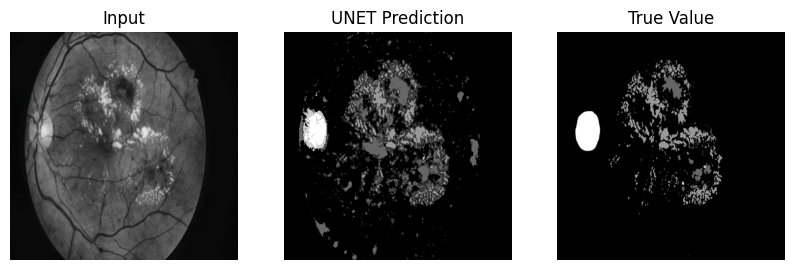

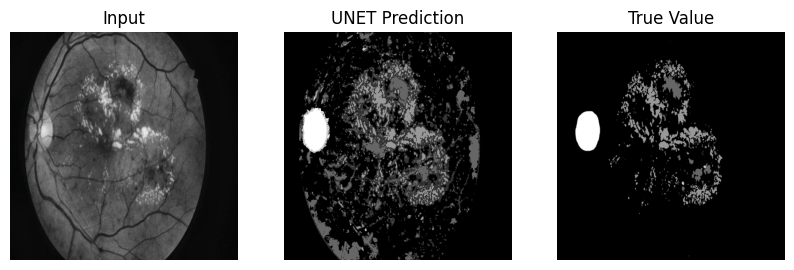

In [24]:
best_model, last_model = models_list[1]
torch.cuda.empty_cache()
gc.collect()
inference_unet(best_model, True, multiclass_test_dataloader, 1, device)
inference_unet(last_model, True, multiclass_test_dataloader, 1, device)